<a href="https://colab.research.google.com/github/kyjness/Undergraduate-Research-Assistant/blob/main/Deep_Patient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Step 1: 데이터 전처리
# 필요한 라이브러리 임포트
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score, accuracy_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# 데이터 로드 및 확인
data = pd.read_csv('/content/drive/MyDrive/학부연구생/Deep patient/hospital_readmissions.csv')
data.head(10)

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no
5,[40-50),2,51,0,10,0,0,0,Missing,Other,Other,Other,no,no,no,no,yes
6,[50-60),4,44,2,21,0,0,0,Missing,Injury,Other,Other,no,normal,yes,yes,no
7,[60-70),1,19,6,16,0,0,1,Other,Circulatory,Other,Other,no,no,no,yes,yes
8,[80-90),4,67,3,13,0,0,0,InternalMedicine,Digestive,Other,Other,no,no,no,no,yes
9,[70-80),8,37,1,18,0,0,0,Family/GeneralPractice,Respiratory,Respiratory,Other,no,no,yes,yes,no


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                25000 non-null  object
 1   time_in_hospital   25000 non-null  int64 
 2   n_lab_procedures   25000 non-null  int64 
 3   n_procedures       25000 non-null  int64 
 4   n_medications      25000 non-null  int64 
 5   n_outpatient       25000 non-null  int64 
 6   n_inpatient        25000 non-null  int64 
 7   n_emergency        25000 non-null  int64 
 8   medical_specialty  25000 non-null  object
 9   diag_1             25000 non-null  object
 10  diag_2             25000 non-null  object
 11  diag_3             25000 non-null  object
 12  glucose_test       25000 non-null  object
 13  A1Ctest            25000 non-null  object
 14  change             25000 non-null  object
 15  diabetes_med       25000 non-null  object
 16  readmitted         25000 non-null  objec

In [ ]:
#각 열별 고유값 개수
for col in data.columns:
    print(f"Column '{col}': {data[col].nunique()} unique values")

Column 'age': 6 unique values
Column 'time_in_hospital': 14 unique values
Column 'n_lab_procedures': 109 unique values
Column 'n_procedures': 7 unique values
Column 'n_medications': 70 unique values
Column 'n_outpatient': 23 unique values
Column 'n_inpatient': 16 unique values
Column 'n_emergency': 21 unique values
Column 'medical_specialty': 7 unique values
Column 'diag_1': 8 unique values
Column 'diag_2': 8 unique values
Column 'diag_3': 8 unique values
Column 'glucose_test': 3 unique values
Column 'A1Ctest': 3 unique values
Column 'change': 2 unique values
Column 'diabetes_med': 2 unique values
Column 'readmitted': 2 unique values


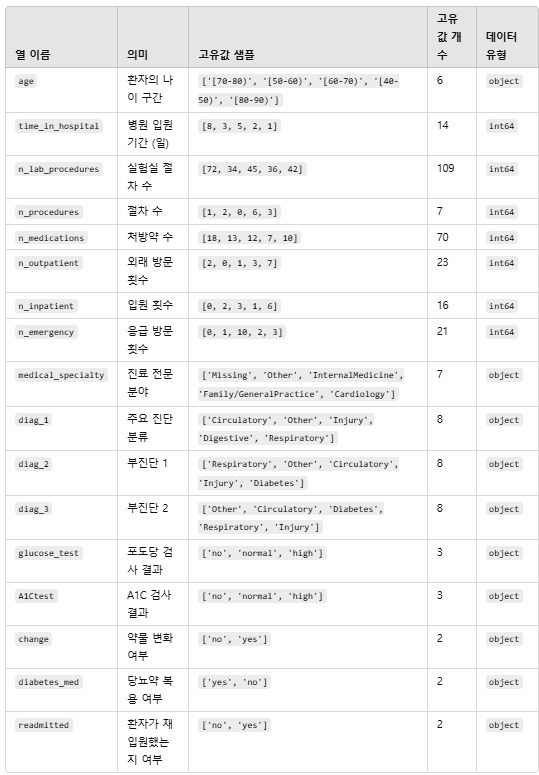

In [ ]:
# Step 2: 변수 유형 자동 구분
# data.info()를 활용하여 변수의 데이터 타입 기반으로 범주형/연속형 변수 구분
categorical_columns = data.select_dtypes(include=['object']).columns.tolist()
numerical_columns = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

# 'readmitted' 변수는 예측 대상이므로 별도로 처리
categorical_columns.remove('readmitted')

print("Step 2: 범주형 변수:", categorical_columns)
print("Step 2: 연속형 변수:", numerical_columns)

Step 2: 범주형 변수: ['age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest', 'change', 'diabetes_med']
Step 2: 연속형 변수: ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']


In [ ]:
# Step 3: 범주형 데이터 인코딩
# LabelEncoder를 사용하여 범주형 데이터를 숫자로 변환
label_encoders = {col: LabelEncoder() for col in categorical_columns + ['readmitted']}
for col in categorical_columns + ['readmitted']:
    data[col] = label_encoders[col].fit_transform(data[col])
print(data[categorical_columns].head())

   age  medical_specialty  diag_1  diag_2  diag_3  glucose_test  A1Ctest  \
0    3                  4       0       7       6             1        1   
1    3                  5       6       6       6             1        1   
2    1                  4       0       0       0             1        1   
3    3                  4       0       6       1             1        1   
4    2                  3       6       0       7             1        1   

   change  diabetes_med  
0       0             1  
1       0             1  
2       1             1  
3       1             1  
4       0             1  


In [ ]:
# Step 4: 수치형 데이터 정규화
# MinMaxScaler를 사용하여 0과 1 사이로 정규화
scaler = MinMaxScaler()
data[numerical_columns] = scaler.fit_transform(data[numerical_columns])
print(data[numerical_columns].head())

   time_in_hospital  n_lab_procedures  n_procedures  n_medications  \
0          0.538462          0.633929      0.166667       0.217949   
1          0.153846          0.294643      0.333333       0.153846   
2          0.307692          0.392857      0.000000       0.217949   
3          0.076923          0.312500      0.000000       0.141026   
4          0.000000          0.366071      0.000000       0.076923   

   n_outpatient  n_inpatient  n_emergency  
0      0.060606          0.0          0.0  
1      0.000000          0.0          0.0  
2      0.000000          0.0          0.0  
3      0.030303          0.0          0.0  
4      0.000000          0.0          0.0  


In [ ]:
# Step 5: 데이터셋 분리
# 'readmitted' 열을 예측 대상(y)으로 설정하고 나머지를 특성(X)으로 분리
X = data.drop('readmitted', axis=1)
y = data['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Train 데이터 크기: {X_train.shape}, Test 데이터 크기: {X_test.shape}")

Train 데이터 크기: (20000, 16), Test 데이터 크기: (5000, 16)


In [ ]:
# Step 6: Denoising Autoencoder 모델 구성
# 입력 차원과 압축 차원 정의
input_dim = X_train.shape[1]
encoding_dim = 128
hidden_dim = 64

# Autoencoder 구성
input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='sigmoid')(input_layer)
encoded = Dropout(0.2)(encoded)
encoded = Dense(hidden_dim, activation='sigmoid')(encoded)
decoded = Dense(encoding_dim, activation='sigmoid')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# 모델 정의
autoencoder = Model(inputs=input_layer, outputs=decoded)
encoder = Model(inputs=input_layer, outputs=encoded)
autoencoder.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss='binary_crossentropy')

In [ ]:
# Step 7: Autoencoder 학습
history = autoencoder.fit(X_train, X_train, epochs=100, batch_size=256, shuffle=True, validation_split=0.2, verbose=1)

Epoch 1/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: -0.0066 - val_loss: -1.8862
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: -2.4801 - val_loss: -4.4273
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: -5.1685 - val_loss: -7.7213
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: -8.7598 - val_loss: -12.2907
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -13.7998 - val_loss: -18.2964
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: -19.8135 - val_loss: -25.2866
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: -27.2357 - val_loss: -32.6889
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: -34.6702 - val_loss: -40.1710
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -41.9441 - val_loss: -47.6396
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: -49.8803 - val_loss: -55.0687
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: -56.5495 - val_loss: -62.4761
Epoch 12/100
63/63 ━

In [ ]:
# Step 8: 심층 표현 추출
# 학습된 Encoder를 사용해 데이터를 심층 표현으로 변환
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)
print(f"Encoded Train 데이터 크기: {X_train_encoded.shape}, Encoded Test 데이터 크기: {X_test_encoded.shape}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Encoded Train 데이터 크기: (20000, 64), Encoded Test 데이터 크기: (5000, 64)


In [ ]:
# Step 9: 랜덤 포레스트 학습 및 평가
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_encoded, y_train)

# 예측 및 평가
threshold = 0.6
y_pred = (rf_model.predict_proba(X_test_encoded)[:, 1] > threshold).astype(int)
y_pred_proba = rf_model.predict_proba(X_test_encoded)[:, 1]

roc_auc = roc_auc_score(y_test, y_pred_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

results = {
    'ROC AUC': roc_auc,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Accuracy': accuracy
}
print("평가 결과:", results)


평가 결과: {'ROC AUC': 0.5525068449403344, 'Precision': 0.5134357005758158, 'Recall': 0.22843723313407344, 'F1-Score': 0.31619385342789597, 'Accuracy': 0.5372}


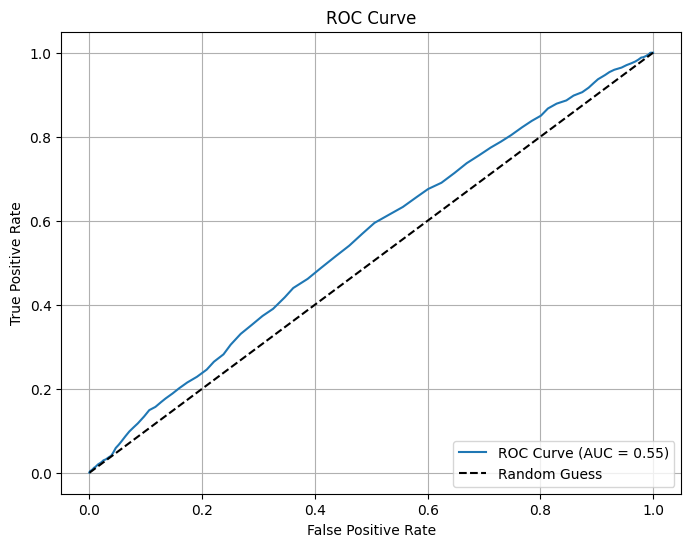

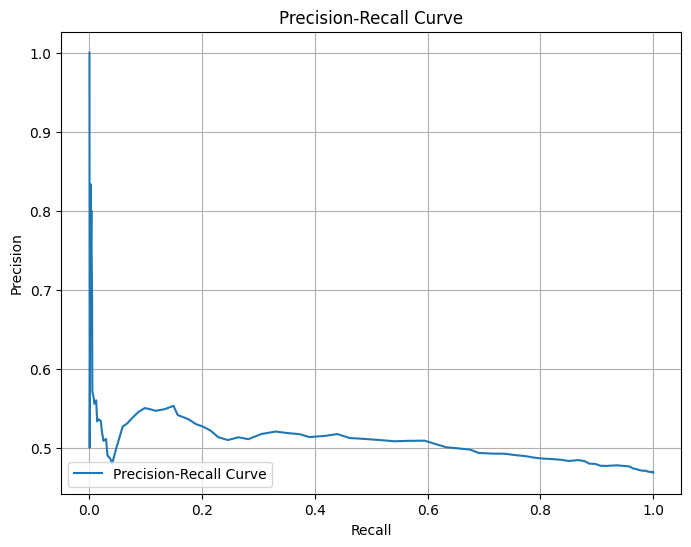

최종 평가 결과: {'ROC AUC': 0.5525068449403344, 'Precision': 0.5134357005758158, 'Recall': 0.22843723313407344, 'F1-Score': 0.31619385342789597, 'Accuracy': 0.5372}


In [ ]:
# Step 10: 결과 시각화
# ROC 커브
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Precision-Recall Curve
from sklearn.metrics import precision_recall_curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(8, 6))
plt.plot(recall_vals, precision_vals, label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="lower left")
plt.grid()
plt.show()

print("최종 평가 결과:", results)

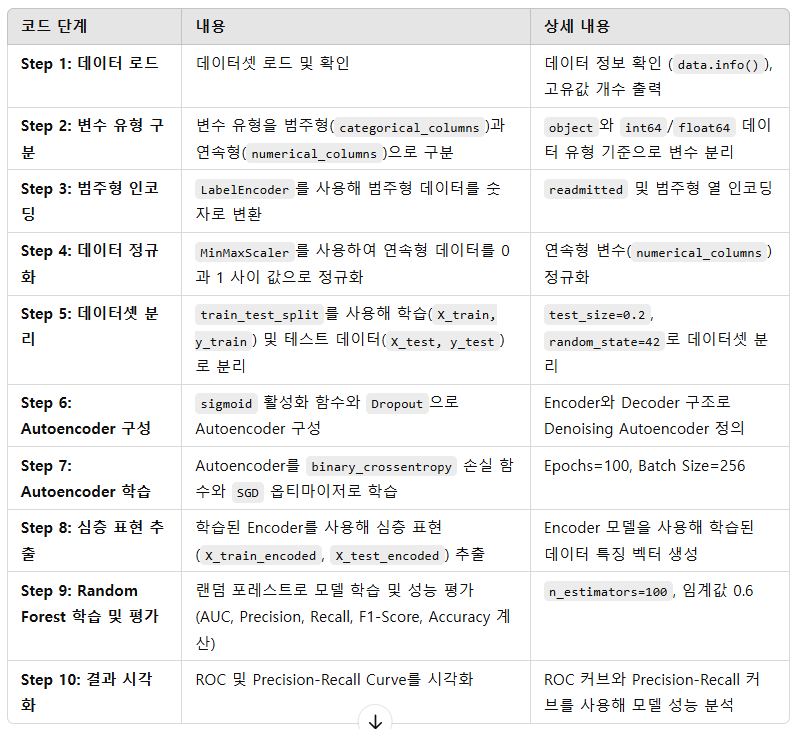